In [37]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from shutil import copyfile
from sklearn.model_selection import train_test_split
from IPython.display import SVG,display
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.utils import to_categorical
from keras.applications import VGG16
from keras.applications.vgg16 import decode_predictions
from keras.preprocessing.image import load_img
from keras.utils.vis_utils import model_to_dot

In [2]:
def createDirectoryEnvironment(train_data, train_targets, val_data, val_targets, path):
    trainpath = path + 'train/'
    valpath = path + 'validation/'
    if(os.listdir() == 2):
        return trainpath,valpath
    if(not os.path.exists(trainpath)):
        os.mkdir(trainpath)
    if(not os.path.exists(valpath)):
        os.mkdir(valpath)
        
    classes = train_targets.columns.append(val_targets.columns).drop_duplicates()  
    for c in classes:
        train_class = trainpath + c + '/'
        val_class = valpath + c + '/'
        if(not os.path.exists(train_class)):
            os.mkdir(train_class)
        if(not os.path.exists(val_class)):
            os.mkdir(val_class)
            
    for f in train_data.index.values:
        copyfile(path + '../CV/' + f[:f.find('frame')-1] + '/icm/' + f, trainpath + train_targets.loc[f].idxmax(axis = 1) + '/' + f)
    for f in val_data.index.values:
        copyfile(path + '../CV/' + f[:f.find('frame')-1] + '/icm/' + f, valpath + val_targets.loc[f].idxmax(axis = 1) + '/' + f)
    
    return trainpath, valpath

def splitImagesByAspectRatio(path):
    for folder in os.listdir(path):
        for file in os.listdir(path + folder):
            img = cv2.imread(path + folder + "/" + file)
            height, width, channels = img.shape
            aspect_ratio = width/height
            createSquaredImages(img, aspect_ratio, path,folder,file)

def createSquaredImages(img, aspect_ratio, path,folder,file):
    if(aspect_ratio == 4/3):
        square_shape = img.shape[0] // 3
    else:
        square_shape = img.shape[0] // 9
    count = 0
    for i in np.arange(0,img.shape[0],square_shape):
        for j in np.arange(0, img.shape[1],square_shape):
            subfig = img[i:i+square_shape,j:j+square_shape]
            cv2.imwrite(path + folder + "/" + file.split('.')[0] + '-' + str(count) + '.' + file.split('.')[1], subfig)
            count += 1               

In [56]:
def createTestDirectory(test_data, folder_path):
    test_path = folder_path + 'test/unknown/'
    if(not os.path.exists(test_path)):
        os.mkdir(test_path)
    for f in test_data.filename:
        print(f)
        copyfile(folder_path + 'CV/' + f[:f.find('frame')-1] + '/icm/' + f, test_path + f)
    return '/'.join(test_path.split('/')[:-2])

In [3]:
folder_path = "/home/diegues/Desktop/ProcessedImages/"
data = pd.read_csv(folder_path + "sampled_data.csv")

filenames = data['filename']
targets = data['level3']

# one-hot encoding
targets_ohe = pd.get_dummies(targets)

# dealing with NaNs
data = data.drop(['roll', 'pitch', 'level1', 'level2', 'level3', 'level4', 
                  'level5', 'level6', 'AphiaID', 'EunisName', 'EunisCode', 
                  'date', 'timestamp', 'species'],
                 axis = 1)

X = data.groupby('filename').max()
Y = pd.concat([filenames,targets_ohe], axis = 1).groupby('filename').max()


# tts
train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size = 0.3, random_state=47)

images_path = '/home/diegues/Desktop/ProcessedImages/SampledData/'
train_dir, val_dir = createDirectoryEnvironment(train_X, train_Y, test_X, test_Y, images_path)

In [14]:
vgg16_ft = VGG16(weights = 'imagenet')
vgg16_ft.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [17]:
x = Dense(7, activation='softmax', name='predictions')(vgg16_ft.layers[-2].output)
eunis_classifier = Model(input=vgg16_ft.input, output=x)

eunis_classifier.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

/home/diegues/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("pr...)`
  


In [18]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
 
validation_datagen = ImageDataGenerator(rescale=1./255)
 
train_batchsize = 1
val_batchsize = 1
 
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=train_batchsize,
        class_mode='categorical')
 
validation_generator = validation_datagen.flow_from_directory(
        val_dir,
        target_size=(224, 224),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)

Found 640 images belonging to 7 classes.
Found 275 images belonging to 7 classes.


In [19]:
sgd_optimizer = SGD(lr=0.001)
eunis_classifier.compile(loss='categorical_crossentropy',
                        optimizer=sgd_optimizer, 
                        metrics=['acc'])
tensorboard = TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)
best_checkpoint = ModelCheckpoint('./weights/eunis_photo_classifier.h5', monitor='val_acc', save_best_only=True, verbose=1)
earlystop = EarlyStopping(monitor='val_acc', patience=10, verbose=1)
reducer = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=3, verbose=1, min_lr=1e-7)

In [20]:
history = eunis_classifier.fit_generator(train_generator, 
                                         steps_per_epoch=len(train_X)//train_batchsize,
                                         epochs=500,
                                         validation_data=validation_generator,
                                         validation_steps = len(test_X)//val_batchsize,
                                         callbacks=[tensorboard, best_checkpoint, earlystop, reducer]
                                        )

Epoch 1/500
640/640 [==============================] - 110s 173ms/step - loss: 2.0497 - acc: 0.1875 - val_loss: 1.9534 - val_acc: 0.1891
Epoch 2/500
640/640 [==============================] - 110s 172ms/step - loss: 1.8653 - acc: 0.1828 - val_loss: 1.8551 - val_acc: 0.2327
Epoch 3/500
640/640 [==============================] - 110s 172ms/step - loss: 1.8594 - acc: 0.2094 - val_loss: 1.7824 - val_acc: 0.2255
Epoch 4/500
640/640 [==============================] - 110s 172ms/step - loss: 1.7888 - acc: 0.2594 - val_loss: 1.6879 - val_acc: 0.3455
Epoch 5/500
640/640 [==============================] - 110s 172ms/step - loss: 1.7108 - acc: 0.2734 - val_loss: 1.5808 - val_acc: 0.2509
Epoch 6/500
640/640 [==============================] - 111s 173ms/step - loss: 1.6230 - acc: 0.3422 - val_loss: 1.4620 - val_acc: 0.3636
Epoch 7/500
640/640 [==============================] - 111s 173ms/step - loss: 1.5563 - acc: 0.3734 - val_loss: 1.2754 - val_acc: 0.5200
Epoch 8/500
640/640 [====================

640/640 [==============================] - 110s 171ms/step - loss: 0.0500 - acc: 0.9859 - val_loss: 0.2260 - val_acc: 0.9418
Epoch 57/500
640/640 [==============================] - 110s 172ms/step - loss: 0.0622 - acc: 0.9844 - val_loss: 0.2272 - val_acc: 0.9418
Epoch 58/500
640/640 [==============================] - 110s 172ms/step - loss: 0.0557 - acc: 0.9828 - val_loss: 0.2273 - val_acc: 0.9418

Epoch 00058: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.
Epoch 59/500
640/640 [==============================] - 110s 172ms/step - loss: 0.0543 - acc: 0.9891 - val_loss: 0.2275 - val_acc: 0.9418
Epoch 60/500
640/640 [==============================] - 110s 172ms/step - loss: 0.0490 - acc: 0.9953 - val_loss: 0.2276 - val_acc: 0.9418
Epoch 61/500
640/640 [==============================] - 110s 172ms/step - loss: 0.0527 - acc: 0.9859 - val_loss: 0.2266 - val_acc: 0.9418

Epoch 00061: ReduceLROnPlateau reducing learning rate to 9.765625463842298e-07.
Epoch 62/500
640/640 [

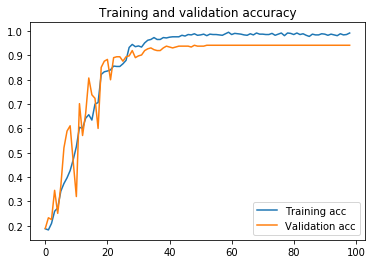

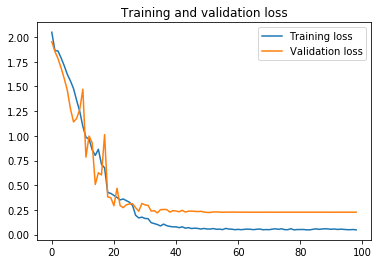

In [34]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.savefig('train_val_acc.jpg')

plt.figure()
 
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig('train_val_loss.jpg')
plt.show()

275/275 [==============================] - 7s 26ms/step
No of errors = 16/275


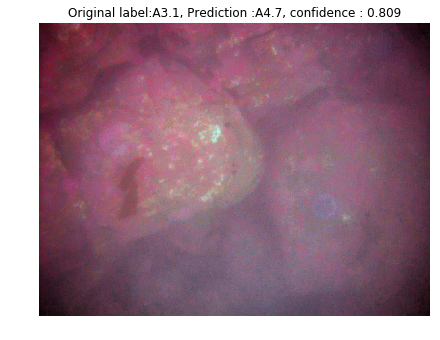

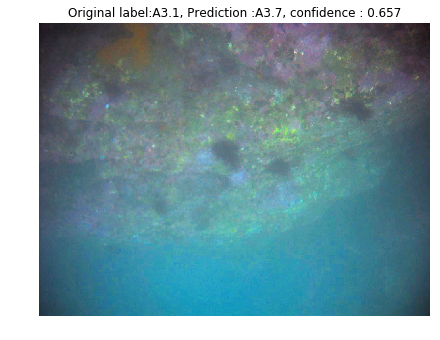

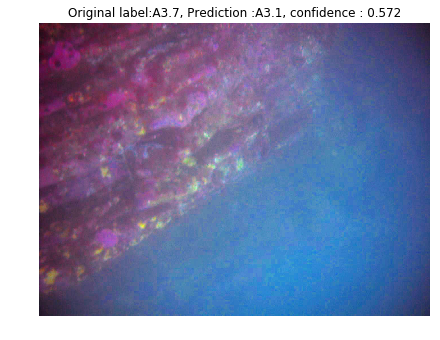

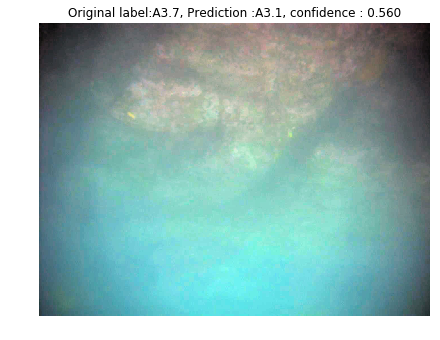

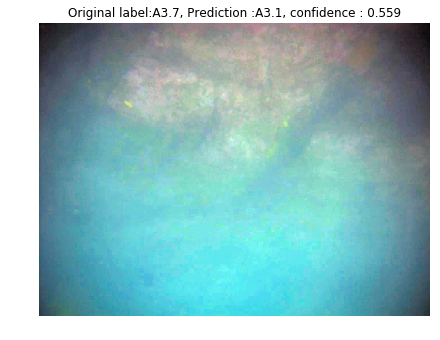

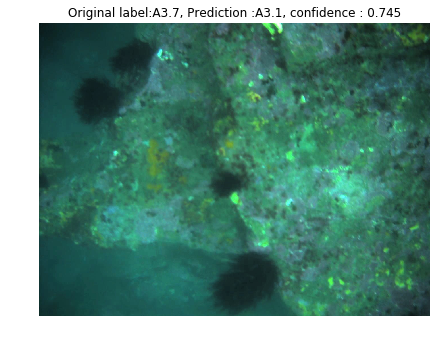

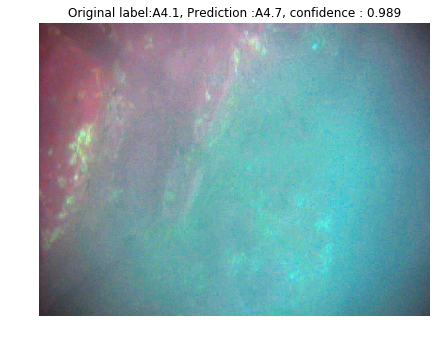

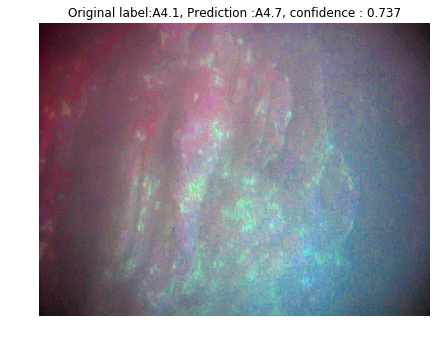

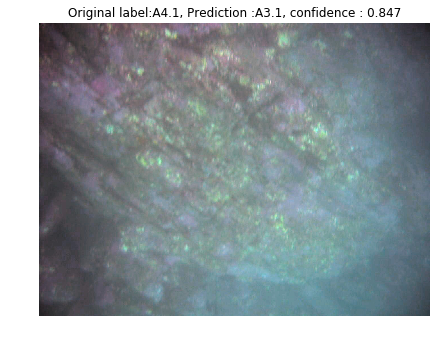

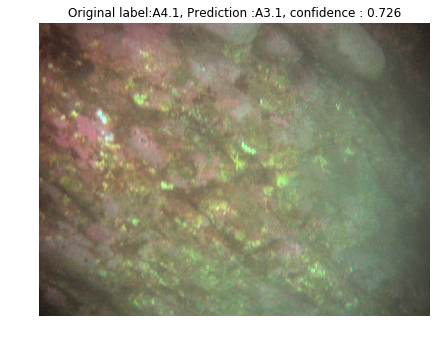

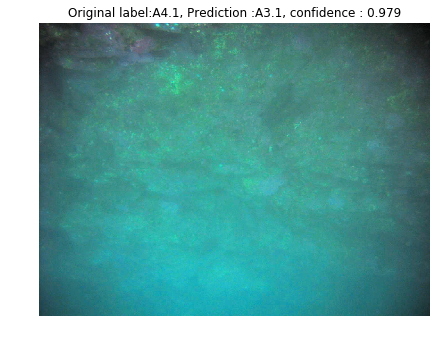

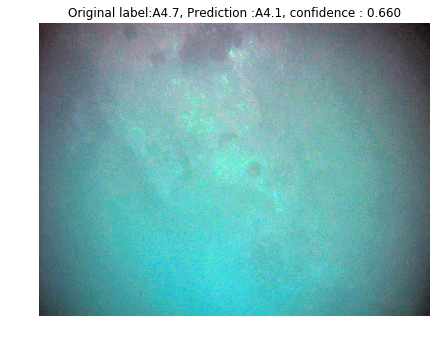

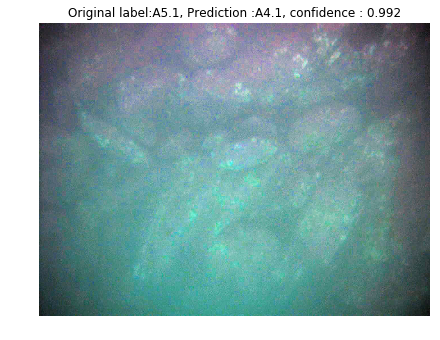

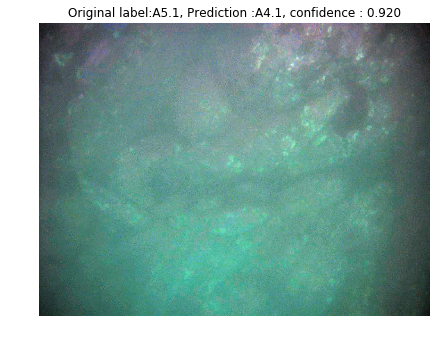

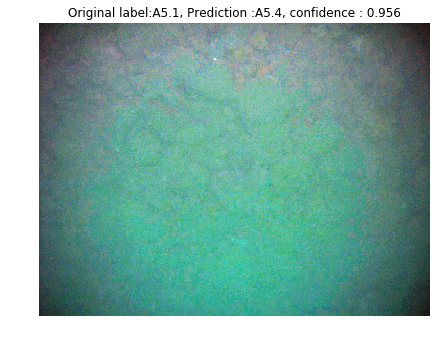

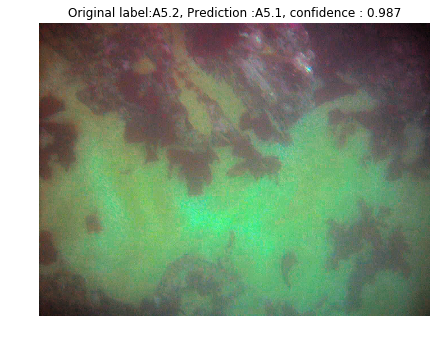

In [30]:
fnames = validation_generator.filenames
 
# Get the ground truth from generator
ground_truth = validation_generator.classes
 
# Get the label to class mapping from the generator
label2index = validation_generator.class_indices
 
# Getting the mapping from class index to class label
idx2label = dict((v,k) for k,v in label2index.items())
predictions = eunis_classifier.predict_generator(validation_generator, steps=validation_generator.samples/validation_generator.batch_size,verbose=1)
predicted_classes = np.argmax(predictions,axis=1)
 
errors = np.where(predicted_classes != ground_truth)[0]
print("No of errors = {}/{}".format(len(errors),validation_generator.samples))
 
# Show the errors
for i in range(len(errors)):
    pred_class = np.argmax(predictions[errors[i]])
    pred_label = idx2label[pred_class]
     
    title = 'Original label:{}, Prediction :{}, confidence : {:.3f}'.format(
        fnames[errors[i]].split('/')[0],
        pred_label,
        predictions[errors[i]][pred_class])
     
    original = load_img('{}/{}'.format(val_dir,fnames[errors[i]]))
    plt.figure(figsize=[7,7])
    plt.axis('off')
    plt.title(title)
    plt.imshow(original)
    plt.show()

In [38]:
modelSVG=SVG(model_to_dot(eunis_classifier,show_shapes=True).create(prog='dot', format='svg'))
display(modelSVG)

ImportError: Failed to import `pydot`. Please install `pydot`. For example with `pip install pydot`.

In [57]:
folder_path = '/home/diegues/Desktop/ProcessedImages/'
test_data = pd.read_csv(folder_path + 'unlabeled_data.csv')
test_dir = createTestDirectory(test_data, folder_path)

132143_forcadinho-np3_frame7.jpg
132143_forcadinho-np3_frame8.jpg
132143_forcadinho-np3_frame9.jpg
132143_forcadinho-np3_frame10.jpg
132143_forcadinho-np3_frame11.jpg
132143_forcadinho-np3_frame12.jpg
132143_forcadinho-np3_frame13.jpg
132143_forcadinho-np3_frame15.jpg
132143_forcadinho-np3_frame16.jpg
132143_forcadinho-np3_frame17.jpg
132143_forcadinho-np3_frame19.jpg
132143_forcadinho-np3_frame20.jpg
132143_forcadinho-np3_frame21.jpg
132143_forcadinho-np3_frame22.jpg
132143_forcadinho-np3_frame24.jpg
132143_forcadinho-np3_frame25.jpg
132143_forcadinho-np3_frame27.jpg
132143_forcadinho-np3_frame28.jpg
132143_forcadinho-np3_frame29.jpg
132143_forcadinho-np3_frame30.jpg
132143_forcadinho-np3_frame31.jpg
132143_forcadinho-np3_frame33.jpg
132143_forcadinho-np3_frame34.jpg
132143_forcadinho-np3_frame35.jpg
132143_forcadinho-np3_frame36.jpg
132143_forcadinho-np3_frame37.jpg
132143_forcadinho-np3_frame60.jpg
132143_forcadinho-np3_frame61.jpg
132143_forcadinho-np3_frame62.jpg
132143_forcadinho

132143_forcadinho-np3_frame584.jpg
132143_forcadinho-np3_frame586.jpg
132143_forcadinho-np3_frame587.jpg
132143_forcadinho-np3_frame588.jpg
132143_forcadinho-np3_frame590.jpg
132143_forcadinho-np3_frame591.jpg
132143_forcadinho-np3_frame592.jpg
132143_forcadinho-np3_frame596.jpg
132143_forcadinho-np3_frame597.jpg
132143_forcadinho-np3_frame598.jpg
132143_forcadinho-np3_frame599.jpg
132143_forcadinho-np3_frame604.jpg
132143_forcadinho-np3_frame605.jpg
132143_forcadinho-np3_frame606.jpg
132143_forcadinho-np3_frame607.jpg
132143_forcadinho-np3_frame609.jpg
132143_forcadinho-np3_frame610.jpg
132143_forcadinho-np3_frame611.jpg
132143_forcadinho-np3_frame612.jpg
132143_forcadinho-np3_frame613.jpg
132143_forcadinho-np3_frame617.jpg
132143_forcadinho-np3_frame618.jpg
132143_forcadinho-np3_frame619.jpg
132143_forcadinho-np3_frame620.jpg
132143_forcadinho-np3_frame621.jpg
132143_forcadinho-np3_frame622.jpg
132143_forcadinho-np3_frame624.jpg
132143_forcadinho-np3_frame625.jpg
132143_forcadinho-np

132143_forcadinho-np3_frame1200.jpg
132143_forcadinho-np3_frame1201.jpg
132143_forcadinho-np3_frame1203.jpg
132143_forcadinho-np3_frame1204.jpg
132143_forcadinho-np3_frame1205.jpg
132143_forcadinho-np3_frame1206.jpg
132143_forcadinho-np3_frame1207.jpg
132143_forcadinho-np3_frame1208.jpg
132143_forcadinho-np3_frame1209.jpg
132143_forcadinho-np3_frame1210.jpg
132143_forcadinho-np3_frame1211.jpg
132143_forcadinho-np3_frame1212.jpg
132143_forcadinho-np3_frame1213.jpg
132143_forcadinho-np3_frame1214.jpg
132143_forcadinho-np3_frame1215.jpg
132143_forcadinho-np3_frame1216.jpg
132143_forcadinho-np3_frame1218.jpg
132143_forcadinho-np3_frame1219.jpg
132143_forcadinho-np3_frame1220.jpg
132143_forcadinho-np3_frame1221.jpg
132143_forcadinho-np3_frame1225.jpg
132143_forcadinho-np3_frame1227.jpg
132143_forcadinho-np3_frame1229.jpg
132143_forcadinho-np3_frame1230.jpg
132143_forcadinho-np3_frame1231.jpg
132143_forcadinho-np3_frame1232.jpg
132143_forcadinho-np3_frame1233.jpg
132143_forcadinho-np3_frame1

132143_forcadinho-np3_frame1511.jpg
132143_forcadinho-np3_frame1512.jpg
132143_forcadinho-np3_frame1513.jpg
132143_forcadinho-np3_frame1514.jpg
132143_forcadinho-np3_frame1515.jpg
132143_forcadinho-np3_frame1516.jpg
132143_forcadinho-np3_frame1517.jpg
132143_forcadinho-np3_frame1518.jpg
132143_forcadinho-np3_frame1519.jpg
132143_forcadinho-np3_frame1520.jpg
132143_forcadinho-np3_frame1521.jpg
132143_forcadinho-np3_frame1522.jpg
132143_forcadinho-np3_frame1523.jpg
132143_forcadinho-np3_frame1524.jpg
132143_forcadinho-np3_frame1525.jpg
132143_forcadinho-np3_frame1526.jpg
132143_forcadinho-np3_frame1528.jpg
132143_forcadinho-np3_frame1529.jpg
132143_forcadinho-np3_frame1530.jpg
132143_forcadinho-np3_frame1531.jpg
132143_forcadinho-np3_frame1532.jpg
132143_forcadinho-np3_frame1533.jpg
132143_forcadinho-np3_frame1534.jpg
132143_forcadinho-np3_frame1535.jpg
132143_forcadinho-np3_frame1536.jpg
132143_forcadinho-np3_frame1537.jpg
132143_forcadinho-np3_frame1538.jpg
132143_forcadinho-np3_frame1

132143_forcadinho-np3_frame2108.jpg
132143_forcadinho-np3_frame2109.jpg
132143_forcadinho-np3_frame2110.jpg
132143_forcadinho-np3_frame2111.jpg
132143_forcadinho-np3_frame2112.jpg
132143_forcadinho-np3_frame2113.jpg
132143_forcadinho-np3_frame2114.jpg
132143_forcadinho-np3_frame2115.jpg
132143_forcadinho-np3_frame2116.jpg
132143_forcadinho-np3_frame2117.jpg
132143_forcadinho-np3_frame2118.jpg
132143_forcadinho-np3_frame2119.jpg
132143_forcadinho-np3_frame2122.jpg
132143_forcadinho-np3_frame2124.jpg
132143_forcadinho-np3_frame2128.jpg
132143_forcadinho-np3_frame2129.jpg
132143_forcadinho-np3_frame2130.jpg
132143_forcadinho-np3_frame2131.jpg
132143_forcadinho-np3_frame2132.jpg
132143_forcadinho-np3_frame2133.jpg
132143_forcadinho-np3_frame2134.jpg
132143_forcadinho-np3_frame2135.jpg
132143_forcadinho-np3_frame2136.jpg
132143_forcadinho-np3_frame2137.jpg
132143_forcadinho-np3_frame2138.jpg
132143_forcadinho-np3_frame2140.jpg
132143_forcadinho-np3_frame2158.jpg
132143_forcadinho-np3_frame2

132143_forcadinho-np3_frame2866.jpg
132143_forcadinho-np3_frame2867.jpg
132143_forcadinho-np3_frame2868.jpg
132143_forcadinho-np3_frame2869.jpg
132143_forcadinho-np3_frame2870.jpg
132143_forcadinho-np3_frame2871.jpg
132143_forcadinho-np3_frame2872.jpg
132143_forcadinho-np3_frame2873.jpg
132143_forcadinho-np3_frame2874.jpg
132143_forcadinho-np3_frame2875.jpg
132143_forcadinho-np3_frame2876.jpg
132143_forcadinho-np3_frame2877.jpg
132143_forcadinho-np3_frame2878.jpg
132143_forcadinho-np3_frame2879.jpg
132143_forcadinho-np3_frame2880.jpg
132143_forcadinho-np3_frame2881.jpg
132143_forcadinho-np3_frame2882.jpg
132143_forcadinho-np3_frame2883.jpg
132143_forcadinho-np3_frame2884.jpg
132143_forcadinho-np3_frame2885.jpg
132143_forcadinho-np3_frame2886.jpg
132143_forcadinho-np3_frame2887.jpg
132143_forcadinho-np3_frame2888.jpg
132143_forcadinho-np3_frame2889.jpg
132143_forcadinho-np3_frame2890.jpg
132143_forcadinho-np3_frame2891.jpg
132143_forcadinho-np3_frame2892.jpg
132143_forcadinho-np3_frame2

132143_forcadinho-np3_frame3183.jpg
132143_forcadinho-np3_frame3184.jpg
132143_forcadinho-np3_frame3185.jpg
132143_forcadinho-np3_frame3186.jpg
132143_forcadinho-np3_frame3187.jpg
132143_forcadinho-np3_frame3188.jpg
132143_forcadinho-np3_frame3189.jpg
132143_forcadinho-np3_frame3190.jpg
132143_forcadinho-np3_frame3191.jpg
132143_forcadinho-np3_frame3192.jpg
132143_forcadinho-np3_frame3193.jpg
132143_forcadinho-np3_frame3194.jpg
132143_forcadinho-np3_frame3195.jpg
132143_forcadinho-np3_frame3196.jpg
132143_forcadinho-np3_frame3197.jpg
132143_forcadinho-np3_frame3198.jpg
132143_forcadinho-np3_frame3199.jpg
132143_forcadinho-np3_frame3200.jpg
132143_forcadinho-np3_frame3201.jpg
132143_forcadinho-np3_frame3202.jpg
132143_forcadinho-np3_frame3203.jpg
132143_forcadinho-np3_frame3204.jpg
132143_forcadinho-np3_frame3205.jpg
132143_forcadinho-np3_frame3206.jpg
132143_forcadinho-np3_frame3207.jpg
132143_forcadinho-np3_frame3208.jpg
132143_forcadinho-np3_frame3209.jpg
132143_forcadinho-np3_frame3

132143_forcadinho-np3_frame3442.jpg
132143_forcadinho-np3_frame3444.jpg
132143_forcadinho-np3_frame3445.jpg
132143_forcadinho-np3_frame3446.jpg
132143_forcadinho-np3_frame3448.jpg
132143_forcadinho-np3_frame3449.jpg
132143_forcadinho-np3_frame3450.jpg
132143_forcadinho-np3_frame3451.jpg
132143_forcadinho-np3_frame3452.jpg
132143_forcadinho-np3_frame3453.jpg
132143_forcadinho-np3_frame3454.jpg
132143_forcadinho-np3_frame3455.jpg
132143_forcadinho-np3_frame3456.jpg
132143_forcadinho-np3_frame3457.jpg
132143_forcadinho-np3_frame3458.jpg
132143_forcadinho-np3_frame3459.jpg
132143_forcadinho-np3_frame3460.jpg
132143_forcadinho-np3_frame3462.jpg
132143_forcadinho-np3_frame3463.jpg
132143_forcadinho-np3_frame3464.jpg
132143_forcadinho-np3_frame3465.jpg
132143_forcadinho-np3_frame3466.jpg
132143_forcadinho-np3_frame3467.jpg
132143_forcadinho-np3_frame3468.jpg
132143_forcadinho-np3_frame3469.jpg
132143_forcadinho-np3_frame3470.jpg
132143_forcadinho-np3_frame3473.jpg
132143_forcadinho-np3_frame3

132143_forcadinho-np3_frame3750.jpg
132143_forcadinho-np3_frame3751.jpg
132143_forcadinho-np3_frame3752.jpg
132143_forcadinho-np3_frame3753.jpg
132143_forcadinho-np3_frame3756.jpg
132143_forcadinho-np3_frame3759.jpg
132143_forcadinho-np3_frame3760.jpg
132143_forcadinho-np3_frame3761.jpg
132143_forcadinho-np3_frame3763.jpg
132143_forcadinho-np3_frame3766.jpg
132143_forcadinho-np3_frame3768.jpg
132143_forcadinho-np3_frame3769.jpg
132143_forcadinho-np3_frame3771.jpg
132143_forcadinho-np3_frame3772.jpg
132143_forcadinho-np3_frame3777.jpg
132143_forcadinho-np3_frame3780.jpg
132143_forcadinho-np3_frame3782.jpg
132143_forcadinho-np3_frame3784.jpg
132143_forcadinho-np3_frame3786.jpg
132143_forcadinho-np3_frame3788.jpg
132143_forcadinho-np3_frame3789.jpg
132143_forcadinho-np3_frame3790.jpg
132143_forcadinho-np3_frame3791.jpg
132143_forcadinho-np3_frame3792.jpg
132143_forcadinho-np3_frame3793.jpg
132143_forcadinho-np3_frame3794.jpg
132143_forcadinho-np3_frame3796.jpg
132143_forcadinho-np3_frame3

132143_forcadinho-np3_frame4061.jpg
132143_forcadinho-np3_frame4063.jpg
132143_forcadinho-np3_frame4064.jpg
132143_forcadinho-np3_frame4065.jpg
132143_forcadinho-np3_frame4066.jpg
132143_forcadinho-np3_frame4067.jpg
132143_forcadinho-np3_frame4069.jpg
132143_forcadinho-np3_frame4070.jpg
132143_forcadinho-np3_frame4071.jpg
132143_forcadinho-np3_frame4072.jpg
132143_forcadinho-np3_frame4073.jpg
132143_forcadinho-np3_frame4074.jpg
132143_forcadinho-np3_frame4076.jpg
132143_forcadinho-np3_frame4077.jpg
132143_forcadinho-np3_frame4078.jpg
132143_forcadinho-np3_frame4079.jpg
132143_forcadinho-np3_frame4080.jpg
132143_forcadinho-np3_frame4081.jpg
132143_forcadinho-np3_frame4082.jpg
132143_forcadinho-np3_frame4083.jpg
132143_forcadinho-np3_frame4084.jpg
132143_forcadinho-np3_frame4085.jpg
132143_forcadinho-np3_frame4086.jpg
132143_forcadinho-np3_frame4087.jpg
132143_forcadinho-np3_frame4088.jpg
132143_forcadinho-np3_frame4089.jpg
132143_forcadinho-np3_frame4090.jpg
132143_forcadinho-np3_frame4

105317_cam-np3_frame819.jpg
105317_cam-np3_frame820.jpg
105317_cam-np3_frame821.jpg
105317_cam-np3_frame822.jpg
105317_cam-np3_frame823.jpg
105317_cam-np3_frame824.jpg
105317_cam-np3_frame825.jpg
105317_cam-np3_frame826.jpg
105317_cam-np3_frame827.jpg
105317_cam-np3_frame838.jpg
105317_cam-np3_frame839.jpg
105317_cam-np3_frame840.jpg
105317_cam-np3_frame841.jpg
105317_cam-np3_frame842.jpg
105317_cam-np3_frame843.jpg
105317_cam-np3_frame844.jpg
105317_cam-np3_frame845.jpg
105317_cam-np3_frame846.jpg
105317_cam-np3_frame847.jpg
105317_cam-np3_frame848.jpg
105317_cam-np3_frame859.jpg
105317_cam-np3_frame860.jpg
105317_cam-np3_frame861.jpg
105317_cam-np3_frame862.jpg
105317_cam-np3_frame863.jpg
105317_cam-np3_frame864.jpg
105317_cam-np3_frame865.jpg
105317_cam-np3_frame866.jpg
105317_cam-np3_frame867.jpg
105317_cam-np3_frame868.jpg
105317_cam-np3_frame869.jpg
105317_cam-np3_frame870.jpg
105317_cam-np3_frame871.jpg
105317_cam-np3_frame872.jpg
105317_cam-np3_frame873.jpg
105317_cam-np3_frame

105317_cam-np3_frame1941.jpg
105317_cam-np3_frame1942.jpg
105317_cam-np3_frame1944.jpg
105317_cam-np3_frame1945.jpg
105317_cam-np3_frame1946.jpg
105317_cam-np3_frame1947.jpg
105317_cam-np3_frame1948.jpg
105317_cam-np3_frame1949.jpg
105317_cam-np3_frame1951.jpg
105317_cam-np3_frame1952.jpg
105317_cam-np3_frame1953.jpg
105317_cam-np3_frame1954.jpg
105317_cam-np3_frame1956.jpg
105317_cam-np3_frame1958.jpg
105317_cam-np3_frame1959.jpg
105317_cam-np3_frame1960.jpg
105317_cam-np3_frame1961.jpg
105317_cam-np3_frame1963.jpg
105317_cam-np3_frame1964.jpg
105317_cam-np3_frame1965.jpg
105317_cam-np3_frame1966.jpg
105317_cam-np3_frame1972.jpg
105317_cam-np3_frame1973.jpg
105317_cam-np3_frame1974.jpg
105317_cam-np3_frame1975.jpg
105317_cam-np3_frame1976.jpg
105317_cam-np3_frame1977.jpg
105317_cam-np3_frame1978.jpg
105317_cam-np3_frame1979.jpg
105317_cam-np3_frame1980.jpg
105317_cam-np3_frame1981.jpg
105317_cam-np3_frame1982.jpg
105317_cam-np3_frame1983.jpg
105317_cam-np3_frame1984.jpg
105317_cam-np3

125355_forcadinho-np3_frame1130.jpg
125355_forcadinho-np3_frame1131.jpg
125355_forcadinho-np3_frame1132.jpg
125355_forcadinho-np3_frame1133.jpg
125355_forcadinho-np3_frame1134.jpg
125355_forcadinho-np3_frame1135.jpg
125355_forcadinho-np3_frame1136.jpg
125355_forcadinho-np3_frame1137.jpg
125355_forcadinho-np3_frame1138.jpg
125355_forcadinho-np3_frame1139.jpg
125355_forcadinho-np3_frame1140.jpg
125355_forcadinho-np3_frame1141.jpg
125355_forcadinho-np3_frame1142.jpg
125355_forcadinho-np3_frame1165.jpg
125355_forcadinho-np3_frame1167.jpg
125355_forcadinho-np3_frame1169.jpg
125355_forcadinho-np3_frame1171.jpg
125355_forcadinho-np3_frame1172.jpg
125355_forcadinho-np3_frame1173.jpg
125355_forcadinho-np3_frame1174.jpg
125355_forcadinho-np3_frame1175.jpg
125355_forcadinho-np3_frame1176.jpg
125355_forcadinho-np3_frame1177.jpg
125355_forcadinho-np3_frame1178.jpg
125355_forcadinho-np3_frame1179.jpg
125355_forcadinho-np3_frame1180.jpg
125355_forcadinho-np3_frame1181.jpg
125355_forcadinho-np3_frame1

125355_forcadinho-np3_frame1631.jpg
125355_forcadinho-np3_frame1632.jpg
125355_forcadinho-np3_frame1634.jpg
125355_forcadinho-np3_frame1638.jpg
125355_forcadinho-np3_frame1642.jpg
125355_forcadinho-np3_frame1643.jpg
125355_forcadinho-np3_frame1645.jpg
125355_forcadinho-np3_frame1646.jpg
125355_forcadinho-np3_frame1648.jpg
125355_forcadinho-np3_frame1650.jpg
125355_forcadinho-np3_frame1651.jpg
125355_forcadinho-np3_frame1652.jpg
125355_forcadinho-np3_frame1653.jpg
125355_forcadinho-np3_frame1654.jpg
125355_forcadinho-np3_frame1655.jpg
125355_forcadinho-np3_frame1656.jpg
125355_forcadinho-np3_frame1658.jpg
125355_forcadinho-np3_frame1659.jpg
125355_forcadinho-np3_frame1661.jpg
125355_forcadinho-np3_frame1662.jpg
125355_forcadinho-np3_frame1663.jpg
125355_forcadinho-np3_frame1665.jpg
125355_forcadinho-np3_frame1666.jpg
125355_forcadinho-np3_frame1667.jpg
125355_forcadinho-np3_frame1669.jpg
125355_forcadinho-np3_frame1670.jpg
125355_forcadinho-np3_frame1672.jpg
125355_forcadinho-np3_frame1

113610_cam_survey_1_frame369.jpg
113610_cam_survey_1_frame371.jpg
113610_cam_survey_1_frame372.jpg
113610_cam_survey_1_frame373.jpg
113610_cam_survey_1_frame374.jpg
113610_cam_survey_1_frame375.jpg
113610_cam_survey_1_frame376.jpg
113610_cam_survey_1_frame377.jpg
113610_cam_survey_1_frame378.jpg
113610_cam_survey_1_frame379.jpg
113610_cam_survey_1_frame381.jpg
113610_cam_survey_1_frame382.jpg
113610_cam_survey_1_frame383.jpg
113610_cam_survey_1_frame384.jpg
113610_cam_survey_1_frame386.jpg
113610_cam_survey_1_frame388.jpg
113610_cam_survey_1_frame390.jpg
113610_cam_survey_1_frame391.jpg
113610_cam_survey_1_frame392.jpg
113610_cam_survey_1_frame394.jpg
113610_cam_survey_1_frame395.jpg
113610_cam_survey_1_frame396.jpg
113610_cam_survey_1_frame397.jpg
113610_cam_survey_1_frame398.jpg
113610_cam_survey_1_frame400.jpg
113610_cam_survey_1_frame401.jpg
113610_cam_survey_1_frame402.jpg
113610_cam_survey_1_frame408.jpg
113610_cam_survey_1_frame409.jpg
113610_cam_survey_1_frame410.jpg
113610_cam

113610_cam_survey_1_frame870.jpg
113610_cam_survey_1_frame871.jpg
113610_cam_survey_1_frame872.jpg
113610_cam_survey_1_frame873.jpg
113610_cam_survey_1_frame875.jpg
113610_cam_survey_1_frame876.jpg
113610_cam_survey_1_frame880.jpg
113610_cam_survey_1_frame881.jpg
113610_cam_survey_1_frame882.jpg
113610_cam_survey_1_frame883.jpg
113610_cam_survey_1_frame885.jpg
113610_cam_survey_1_frame886.jpg
113610_cam_survey_1_frame887.jpg
113610_cam_survey_1_frame888.jpg
113610_cam_survey_1_frame889.jpg
113610_cam_survey_1_frame890.jpg
113610_cam_survey_1_frame892.jpg
113610_cam_survey_1_frame893.jpg
113610_cam_survey_1_frame894.jpg
113610_cam_survey_1_frame895.jpg
113610_cam_survey_1_frame896.jpg
113610_cam_survey_1_frame897.jpg
113610_cam_survey_1_frame899.jpg
113610_cam_survey_1_frame900.jpg
113610_cam_survey_1_frame901.jpg
113610_cam_survey_1_frame902.jpg
113610_cam_survey_1_frame903.jpg
113610_cam_survey_1_frame905.jpg
113610_cam_survey_1_frame906.jpg
113610_cam_survey_1_frame907.jpg
113610_cam

113610_cam_survey_1_frame1206.jpg
113610_cam_survey_1_frame1207.jpg
113610_cam_survey_1_frame1208.jpg
113610_cam_survey_1_frame1213.jpg
113610_cam_survey_1_frame1214.jpg
113610_cam_survey_1_frame1215.jpg
113610_cam_survey_1_frame1216.jpg
113610_cam_survey_1_frame1217.jpg
113610_cam_survey_1_frame1218.jpg
113610_cam_survey_1_frame1219.jpg
113610_cam_survey_1_frame1220.jpg
113610_cam_survey_1_frame1221.jpg
113610_cam_survey_1_frame1222.jpg
113610_cam_survey_1_frame1224.jpg
113610_cam_survey_1_frame1225.jpg
113610_cam_survey_1_frame1226.jpg
113610_cam_survey_1_frame1227.jpg
113610_cam_survey_1_frame1228.jpg
113610_cam_survey_1_frame1229.jpg
113610_cam_survey_1_frame1230.jpg
113610_cam_survey_1_frame1231.jpg
113610_cam_survey_1_frame1232.jpg
113610_cam_survey_1_frame1233.jpg
113610_cam_survey_1_frame1234.jpg
113610_cam_survey_1_frame1236.jpg
113610_cam_survey_1_frame1237.jpg
113610_cam_survey_1_frame1238.jpg
113610_cam_survey_1_frame1239.jpg
113610_cam_survey_1_frame1240.jpg
113610_cam_sur

113610_cam_survey_1_frame1598.jpg
113610_cam_survey_1_frame1599.jpg
113610_cam_survey_1_frame1600.jpg
113610_cam_survey_1_frame1601.jpg
113610_cam_survey_1_frame1603.jpg
113610_cam_survey_1_frame1609.jpg
113610_cam_survey_1_frame1610.jpg
113610_cam_survey_1_frame1616.jpg
113610_cam_survey_1_frame1618.jpg
113610_cam_survey_1_frame1619.jpg
113610_cam_survey_1_frame1621.jpg
113610_cam_survey_1_frame1622.jpg
113610_cam_survey_1_frame1623.jpg
113610_cam_survey_1_frame1624.jpg
113610_cam_survey_1_frame1625.jpg
113610_cam_survey_1_frame1627.jpg
113610_cam_survey_1_frame1629.jpg
113610_cam_survey_1_frame1630.jpg
113610_cam_survey_1_frame1674.jpg
113610_cam_survey_1_frame1677.jpg
113610_cam_survey_1_frame1679.jpg
113610_cam_survey_1_frame1680.jpg
113610_cam_survey_1_frame1682.jpg
113610_cam_survey_1_frame1683.jpg
113610_cam_survey_1_frame1685.jpg
113610_cam_survey_1_frame1713.jpg
113610_cam_survey_1_frame1716.jpg
113610_cam_survey_1_frame1719.jpg
113610_cam_survey_1_frame1733.jpg
113610_cam_sur

In [59]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(224, 224),
        batch_size=1,
        class_mode=None,
        shuffle=False)

Found 4702 images belonging to 1 classes.


In [60]:
cnn_preds = eunis_classifier.predict_generator(test_generator, 
                          steps=len(test_data), verbose=1)

4702/4702 [==============================] - 119s 25ms/step


In [61]:
cnn_preds = pd.DataFrame(cnn_preds).set_index(test_data.filename)
cnn_preds.columns = test_Y.columns
cnn_preds['level3'] = cnn_preds.idxmax(axis=1)
cnn_preds.head()

A3.1          A3.7      A4.1  \
filename                                                                  
132143_forcadinho-np3_frame7.jpg   5.372038e-05  5.271208e-05  0.146391   
132143_forcadinho-np3_frame8.jpg   8.502016e-07  5.337913e-07  0.009371   
132143_forcadinho-np3_frame9.jpg   1.108012e-04  1.150155e-05  0.617034   
132143_forcadinho-np3_frame10.jpg  2.346526e-03  8.376996e-05  0.589118   
132143_forcadinho-np3_frame11.jpg  2.680670e-04  1.171168e-05  0.982135   

                                       A4.7          A5.1      A5.2  \
filename                                                              
132143_forcadinho-np3_frame7.jpg   0.853418  1.656591e-05  0.000063   
132143_forcadinho-np3_frame8.jpg   0.990568  7.496880e-07  0.000059   
132143_forcadinho-np3_frame9.jpg   0.382811  2.665544e-05  0.000005   
132143_forcadinho-np3_frame10.jpg  0.200293  1.058047e-01  0.024529   
132143_forcadinho-np3_frame11.jpg  0.016749  4.371523e-04  0.000120   

                                           A5.4 level3  
filename                                                
132143_forcadinho-np3_frame7.jpg   5.371492e-06   A4.7  
132143_forcadinho-np3_frame8.jpg   1.519461e-07   A4.7  
132143_forcadinho-np3_frame9.jpg   7.992610e-07   A4.1  
132143_forcadinho-np3_frame10.jpg  7.782456e-02   A4.1  
132143_forcadinho-np3_frame11.jpg  2.787099e-04   A4.1

Text(0.5,1,'Adapted VGG16')

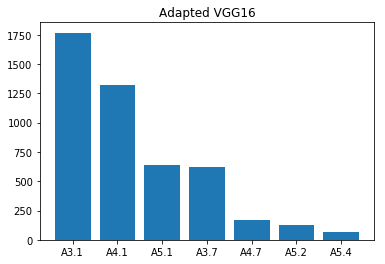

In [62]:
plt.bar(cnn_preds.level3.value_counts().index.tolist(), cnn_preds.level3.value_counts())
plt.title('Adapted VGG16')